# LSTM Model to detect Heel Strike and Toe-off events

In this notebook, we will predict whether each sample is a heel strike or toe-off based on the accelerometer data. To do so, we train an LSTM (Long-Short Term Memory) model on 70% of the data and test it on the remaining 30%

The LSTM architecture has
- a lookback window of 3 timesteps
- 6 features (X,Y,Z acceleration of left foot and right foot) 
- 44 hidden nodes

The first step to select the Subject Id, activity and event of interest

The subsequent steps to tune and test the model are as follows:

1. Subset the data based on subject, activity, and event
2. Oversampling and adding in composite accelerations
3. Remove noise from the data
4. Re-scale each of the features to range (0,5)
5. Split the data into training and testing sets  
6. Since we are using an LSTM architecture, we will implement a look-back function that will introduce historical data determined by the window size
7. Build and compile the Neural Network
8. Fit the model
9. Save the predictions and actual value to evaluate the model. The model is evaluated in terms of 
    - F1 score
    - Percentage of true positives
    - Mean of the absolute difference in time between true positives and corresponding GT events

# Note: before you run the code

You can adjust the subject Id, activity and event in the next cell.
Some parts are specific to indoors/outdoors, so you will need to comment the part if needed, and uncomment it it's if not needed.

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Subset the data based on subject, activity and event


In [172]:
####### Select Subject Id #######
# Key in a number from 1 to 20. 

# 1 to 11: indoors
# 12 to 20: outdoors

SUBJECT_ID = '20'

###### Select Activity ######
# Key in one of the options below:

## For indoors: 
# treadmill_walk
# treadmill_run
# treadmill_walknrun
# treadmill_all (treadmill_walk + treadmill_walknrun + treadmill_slope_walk)
# indoor_walk
# indoor_run
# indoor_walknrun

## For outdoors:
# outdoor_walk
# outdoor_run
# outdoor_walknrun

ACTIVITY = 'outdoor_walknrun'


###### Select Event ######
# LF_HS
# LF_TO
# RF_HS
# RF_TO

EVENT = 'RF_TO'

In [173]:
# read in the data
DATA_PATH = './Combined Data_csv format/'

df = pd.read_csv(DATA_PATH + 'Sub_'+ SUBJECT_ID + '.csv', header = 0)

In [174]:
df = df.drop(df.columns[0], axis=1)
df.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,accY_Wrist,accZ_Wrist,outdoor_walk,outdoor_walk_index,outdoor_walknrun,outdoor_walknrun_index,LF_HS,RF_HS,LF_TO,RF_TO
0,-26.039,-23.373,-3.765,-4.392,-10.510,-2.353,-0.627,-6.118,1.412,8.000,0.941,3.451,1,1,1,1,0.0,0.0,0.0,0.0
1,-29.020,-19.294,-1.098,-4.549,-10.667,-2.196,-0.471,-5.961,1.255,7.843,1.255,3.451,1,2,1,2,0.0,0.0,0.0,0.0
2,-30.588,-17.569,0.471,-4.235,-10.667,-2.510,-0.627,-6.275,0.941,7.529,1.412,3.137,1,3,1,3,0.0,0.0,0.0,0.0
3,-32.941,-13.804,5.176,-5.333,-11.137,-1.725,-0.784,-6.118,0.941,7.373,1.569,3.137,1,4,1,4,0.0,0.0,0.0,0.0
4,-34.196,-11.765,5.647,-5.176,-11.294,-2.353,-0.784,-6.275,1.098,7.059,1.725,3.137,1,5,1,5,0.0,0.0,0.0,0.0


Since there is no indicator variable for treadmill_all for subjects 1-11, let's create another column for this. The value of this data is 1 if either treadmill_walknrun is 1 or treadmill_slope_walk is 1

In [175]:
###############################################
######## Specific to indoors only #############
###############################################

# for SUBJECT_ID 1 to 11, uncomment if otherwise

# def label_treadmill_all (row):
#    if row['treadmill_walknrun'] == 1:
#       return 1
#    if row['treadmill_slope_walk'] == 1:
#       return 1
#    return 0

# df['treadmill_all']=df.apply (lambda row: label_treadmill_all(row),axis=1)

# def label_indoor_run (row):
#    if row['indoor_walknrun'] == 1 and row['indoor_walk'] == 0:
#       return 1
#    return 0

# df['indoor_run']=df.apply (lambda row: label_indoor_run(row),axis=1)

# def label_treadmill_run (row):
#    if row['treadmill_walknrun'] == 1 and row['treadmill_walk'] == 0:
#       return 1
#    return 0

# df['treadmill_run']=df.apply (lambda row: label_indoor_run(row),axis=1)


# df.head()

# ###############################################
# ######## Specific to outdoors only ############
# ###############################################

# for SUBJECT_ID 12 to 20, uncomment if otherwise

def label_outdoor_run (row):
   if row['outdoor_walknrun'] == 1 and row['outdoor_walk'] == 0:
      return 1
   return 0

df['outdoor_run']=df.apply (lambda row: label_outdoor_run(row),axis=1)

df.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,...,accZ_Wrist,outdoor_walk,outdoor_walk_index,outdoor_walknrun,outdoor_walknrun_index,LF_HS,RF_HS,LF_TO,RF_TO,outdoor_run
0,-26.039,-23.373,-3.765,-4.392,-10.510,-2.353,-0.627,-6.118,1.412,8.000,...,3.451,1,1,1,1,0.0,0.0,0.0,0.0,0
1,-29.020,-19.294,-1.098,-4.549,-10.667,-2.196,-0.471,-5.961,1.255,7.843,...,3.451,1,2,1,2,0.0,0.0,0.0,0.0,0
2,-30.588,-17.569,0.471,-4.235,-10.667,-2.510,-0.627,-6.275,0.941,7.529,...,3.137,1,3,1,3,0.0,0.0,0.0,0.0,0
3,-32.941,-13.804,5.176,-5.333,-11.137,-1.725,-0.784,-6.118,0.941,7.373,...,3.137,1,4,1,4,0.0,0.0,0.0,0.0,0
4,-34.196,-11.765,5.647,-5.176,-11.294,-2.353,-0.784,-6.275,1.098,7.059,...,3.137,1,5,1,5,0.0,0.0,0.0,0.0,0


In [176]:
# data munging: change the indicator variable +/- 2 timesteps away from the true value to '1'

def oversample(event):
    global df
    temp_list = []
    for i in range(len(df)):
        if i>=2 and i+3<=len(df):
            if df[event][i-1]==1 or df[event][i]==1 or df[event][i+1]==1:
            # if df[event][i-2]==1 or df[event][i-1]==1 or df[event][i]==1 or df[event][i+1]==1 or df[event][i+2]==1:
                temp_list.append(1)
            else:
                temp_list.append(0)
        else:
            temp_list.append(0)
#     return temp_list
    df[event+'_2']=temp_list

oversample(EVENT)

In [177]:
# Subset out the data by activity of interest

k1=df[df[ACTIVITY]==1]
k1.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,...,outdoor_walk,outdoor_walk_index,outdoor_walknrun,outdoor_walknrun_index,LF_HS,RF_HS,LF_TO,RF_TO,outdoor_run,RF_TO_2
0,-26.039,-23.373,-3.765,-4.392,-10.510,-2.353,-0.627,-6.118,1.412,8.000,...,1,1,1,1,0.0,0.0,0.0,0.0,0,0
1,-29.020,-19.294,-1.098,-4.549,-10.667,-2.196,-0.471,-5.961,1.255,7.843,...,1,2,1,2,0.0,0.0,0.0,0.0,0,0
2,-30.588,-17.569,0.471,-4.235,-10.667,-2.510,-0.627,-6.275,0.941,7.529,...,1,3,1,3,0.0,0.0,0.0,0.0,0,0
3,-32.941,-13.804,5.176,-5.333,-11.137,-1.725,-0.784,-6.118,0.941,7.373,...,1,4,1,4,0.0,0.0,0.0,0.0,0,0
4,-34.196,-11.765,5.647,-5.176,-11.294,-2.353,-0.784,-6.275,1.098,7.059,...,1,5,1,5,0.0,0.0,0.0,0.0,0,0


In [178]:
# Add in the composite acceleration: sqrt(accX^2+accY^2+accZ^2)
k1['acc_LF'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accY_LF']*k1['accY_LF']+k1['accZ_LF']*k1['accZ_LF'])
k1['acc_RF'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accY_RF']*k1['accY_RF']+k1['accZ_RF']*k1['accZ_RF'])

k1['acc_LF_xy'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accY_LF']*k1['accY_LF'])
k1['acc_RF_xy'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accY_RF']*k1['accY_RF'])

k1['acc_LF_yz'] = np.sqrt(k1['accY_LF']*k1['accY_LF']+k1['accZ_LF']*k1['accZ_LF'])
k1['acc_RF_yz'] = np.sqrt(k1['accY_RF']*k1['accY_RF']+k1['accZ_RF']*k1['accZ_RF'])

k1['acc_LF_xz'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accZ_LF']*k1['accZ_LF'])
k1['acc_RF_xz'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accZ_RF']*k1['accZ_RF'])


In [179]:
# Select the columns you want -- the first few accelerometer data and event of interest
k2 = k1[['accX_LF','accY_LF','accZ_LF','accX_RF','accY_RF','accZ_RF','acc_LF','acc_RF','acc_LF_xy','acc_RF_xy','acc_LF_yz','acc_RF_yz','acc_LF_xz','acc_RF_xz', EVENT, EVENT+'_2']]
k2.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,acc_LF,acc_RF,acc_LF_xy,acc_RF_xy,acc_LF_yz,acc_RF_yz,acc_LF_xz,acc_RF_xz,RF_TO,RF_TO_2
0,-26.039,-23.373,-3.765,-4.392,-10.510,-2.353,35.192355,11.631267,34.990379,11.390775,23.674297,10.770177,26.309784,4.982597,0.0,0
1,-29.020,-19.294,-1.098,-4.549,-10.667,-2.196,34.865806,11.802572,34.848513,11.596477,19.325218,10.890698,29.040765,5.051318,0.0,0
2,-30.588,-17.569,0.471,-4.235,-10.667,-2.510,35.277717,11.748200,35.274573,11.476938,17.575312,10.958330,30.591626,4.922939,0.0,0
3,-32.941,-13.804,5.176,-5.333,-11.137,-1.725,36.089484,12.467930,35.716381,12.348022,14.742503,11.269800,33.345171,5.605044,0.0,0
4,-34.196,-11.765,5.647,-5.176,-11.294,-2.353,36.601506,12.644446,36.163264,12.423583,13.050051,11.536509,34.659126,5.685735,0.0,0


## 2. Remove noise from the data

In [180]:
k2['accX_LF_median']=k2['accX_LF'].rolling(window=3).mean()
k2['accY_LF_median']=k2['accY_LF'].rolling(window=3).mean()
k2['accZ_LF_median']=k2['accZ_LF'].rolling(window=3).mean()
k2['acc_LF_median']=k2['acc_LF'].rolling(window=3).mean()
k2['acc_LF_median_xy']=k2['acc_LF_xy'].rolling(window=3).mean()
k2['acc_LF_median_yz']=k2['acc_LF_yz'].rolling(window=3).mean()
k2['acc_LF_median_xz']=k2['acc_LF_xz'].rolling(window=3).mean()

k2['accX_RF_median']=k2['accX_RF'].rolling(window=3).mean()
k2['accY_RF_median']=k2['accY_RF'].rolling(window=3).mean()
k2['accZ_RF_median']=k2['accZ_RF'].rolling(window=3).mean()
k2['acc_RF_median']=k2['acc_RF'].rolling(window=3).mean()
k2['acc_RF_median_xy']=k2['acc_RF_xy'].rolling(window=3).mean()
k2['acc_RF_median_yz']=k2['acc_RF_yz'].rolling(window=3).mean()
k2['acc_RF_median_xz']=k2['acc_RF_xz'].rolling(window=3).mean()

k2[:10]

/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,acc_LF,acc_RF,acc_LF_xy,acc_RF_xy,...,acc_LF_median_xy,acc_LF_median_yz,acc_LF_median_xz,accX_RF_median,accY_RF_median,accZ_RF_median,acc_RF_median,acc_RF_median_xy,acc_RF_median_yz,acc_RF_median_xz
0,-26.039,-23.373,-3.765,-4.392,-10.510,-2.353,35.192355,11.631267,34.990379,11.390775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-29.020,-19.294,-1.098,-4.549,-10.667,-2.196,34.865806,11.802572,34.848513,11.596477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-30.588,-17.569,0.471,-4.235,-10.667,-2.510,35.277717,11.748200,35.274573,11.476938,...,35.037822,20.191609,28.647392,-4.392000,-10.614667,-2.353000,11.727347,11.488064,10.873068,4.985618
3,-32.941,-13.804,5.176,-5.333,-11.137,-1.725,36.089484,12.467930,35.716381,12.348022,...,35.279822,17.214344,30.992521,-4.705667,-10.823667,-2.143667,12.006234,11.807146,11.039609,5.193100
4,-34.196,-11.765,5.647,-5.176,-11.294,-2.353,36.601506,12.644446,36.163264,12.423583,...,35.718073,15.122622,32.865308,-4.914667,-11.032667,-2.196000,12.286859,12.082848,11.254880,5.404572
5,-36.706,-6.902,2.980,-4.706,-12.392,-2.196,37.467966,13.436164,37.349271,13.255493,...,36.409639,11.770133,34.943688,-5.071667,-11.607667,-2.091333,12.849514,12.675700,11.797128,5.494644
6,-38.118,-4.706,2.039,-4.549,-12.706,-2.353,38.461486,13.699359,38.407400,13.495771,...,37.306645,8.565545,36.552797,-4.810333,-12.130667,-2.300667,13.259990,13.058282,12.347873,5.333471
7,-38.902,-0.627,2.824,-4.863,-13.020,-2.196,39.009405,14.070948,38.907052,13.898531,...,38.221241,5.179784,38.001210,-4.706000,-12.706000,-2.248333,13.735491,13.549932,12.903668,5.216839
8,-36.078,-0.784,3.294,-5.961,-13.804,-1.412,36.236545,15.102241,36.086517,15.036088,...,37.800323,3.802507,37.801642,-5.124333,-13.176667,-1.987000,14.290850,14.143463,13.333986,5.527771
9,-34.196,-2.824,3.765,-6.118,-14.431,-1.882,34.518352,15.786881,34.312409,15.674300,...,36.435326,3.661727,36.545023,-5.647333,-13.751667,-1.830000,14.986690,14.869640,13.877708,5.954238


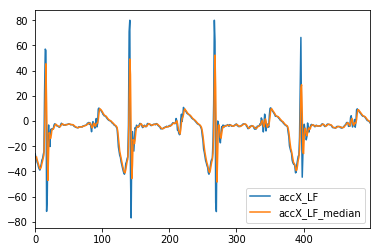

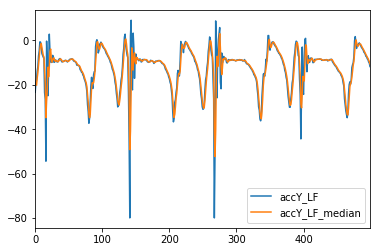

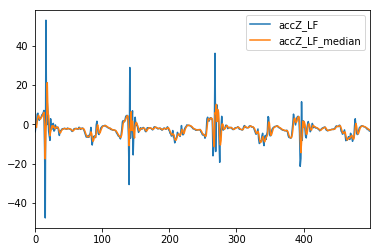

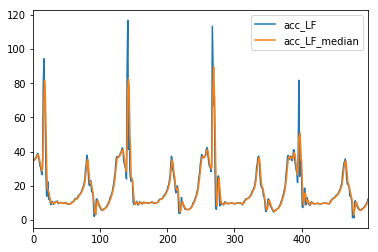

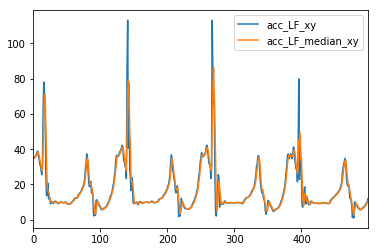

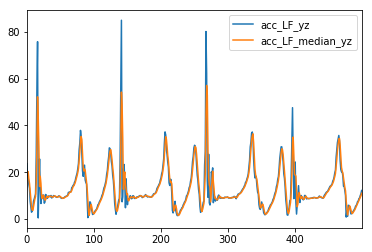

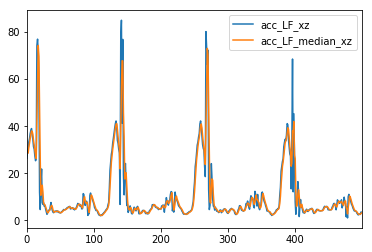

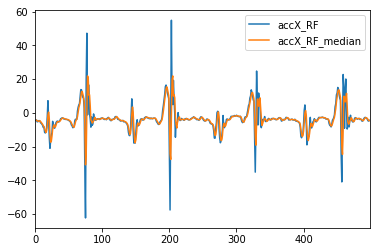

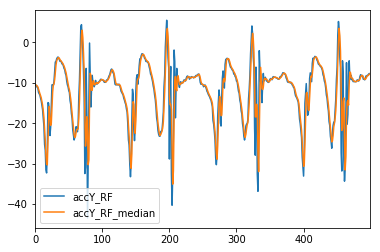

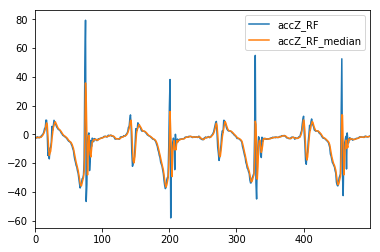

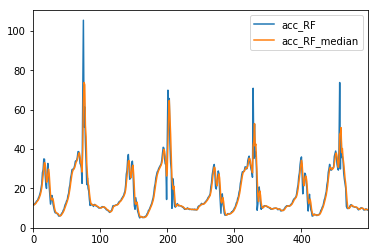

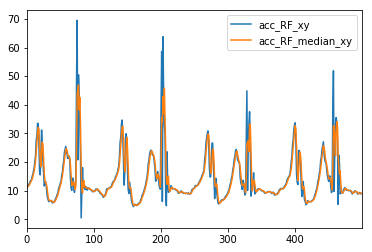

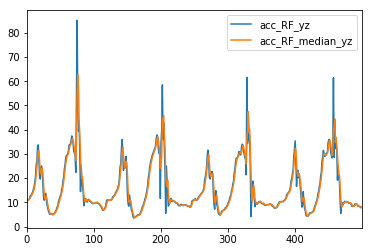

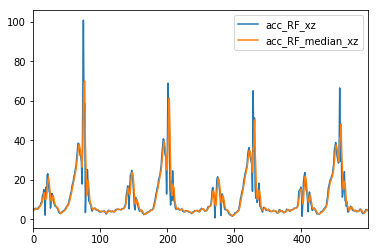

In [181]:
# Visualise
k2[['accX_LF','accX_LF_median']][:500].plot()
k2[['accY_LF','accY_LF_median']][:500].plot()
k2[['accZ_LF','accZ_LF_median']][:500].plot()
k2[['acc_LF','acc_LF_median']][:500].plot()
k2[['acc_LF_xy','acc_LF_median_xy']][:500].plot()
k2[['acc_LF_yz','acc_LF_median_yz']][:500].plot()
k2[['acc_LF_xz','acc_LF_median_xz']][:500].plot()

k2[['accX_RF','accX_RF_median']][:500].plot()
k2[['accY_RF','accY_RF_median']][:500].plot()
k2[['accZ_RF','accZ_RF_median']][:500].plot()
k2[['acc_RF','acc_RF_median']][:500].plot()
k2[['acc_RF_xy','acc_RF_median_xy']][:500].plot()
k2[['acc_RF_yz','acc_RF_median_yz']][:500].plot()
k2[['acc_RF_xz','acc_RF_median_xz']][:500].plot()

In [182]:
# Select the columns you want -- the rolling median accelerometer data and event of interest
# Remove the first two rows which have no accelerometer data
k3 = k2[['accX_LF_median','accY_LF_median','accZ_LF_median','acc_LF_median','acc_LF_median_xy','acc_LF_median_yz','acc_LF_median_xz','accX_RF_median','accY_RF_median','accZ_RF_median','acc_RF_median','acc_RF_median_xy','acc_RF_median_yz', 'acc_RF_median_xz', EVENT, EVENT+'_2']]
k3 = k3.iloc[2:]
k3.head()

,accX_LF_median,accY_LF_median,accZ_LF_median,acc_LF_median,acc_LF_median_xy,acc_LF_median_yz,acc_LF_median_xz,accX_RF_median,accY_RF_median,accZ_RF_median,acc_RF_median,acc_RF_median_xy,acc_RF_median_yz,acc_RF_median_xz,RF_TO,RF_TO_2
2,-28.549000,-20.078667,-1.464000,35.111960,35.037822,20.191609,28.647392,-4.392000,-10.614667,-2.353000,11.727347,11.488064,10.873068,4.985618,0.0,0
3,-30.849667,-16.889000,1.516333,35.411003,35.279822,17.214344,30.992521,-4.705667,-10.823667,-2.143667,12.006234,11.807146,11.039609,5.193100,0.0,0
4,-32.575000,-14.379333,3.764667,35.989569,35.718073,15.122622,32.865308,-4.914667,-11.032667,-2.196000,12.286859,12.082848,11.254880,5.404572,0.0,0
5,-34.614333,-10.823667,4.601000,36.719652,36.409639,11.770133,34.943688,-5.071667,-11.607667,-2.091333,12.849514,12.675700,11.797128,5.494644,0.0,0
6,-36.340000,-7.791000,3.555333,37.510319,37.306645,8.565545,36.552797,-4.810333,-12.130667,-2.300667,13.259990,13.058282,12.347873,5.333471,0.0,0


## 3. Re-scale each of the features to range (0,5)

"LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library."

In [183]:
dataset = k3.values

from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 5))
dataset = scaler.fit_transform(dataset)

## 4. Split the data into training and test sets


In [184]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

22539 9660


In [185]:
print(train)

[[1.60436692 2.43532262 3.03030143 ... 0.25286322 0.         0.        ]
 [1.51196819 2.65444029 3.18732306 ... 0.26419689 0.         0.        ]
 [1.44267584 2.8268446  3.30577859 ... 0.27574852 0.         0.        ]
 ...
 [1.70726124 3.23636497 3.44903163 ... 0.85824568 0.         0.        ]
 [2.56824815 2.7334866  2.80440173 ... 0.99225271 0.         0.        ]
 [4.07182254 1.37570814 2.50962396 ... 1.11669654 0.         0.        ]]


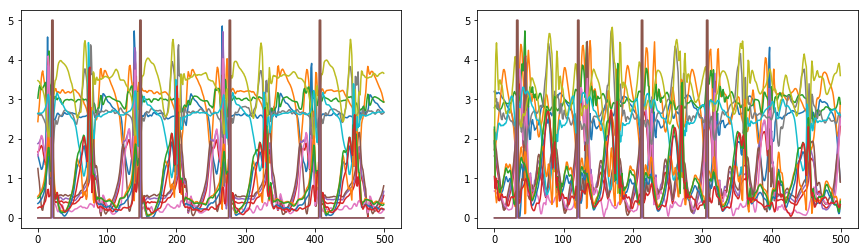

In [186]:
# Example of first 500 and last 500 samples in training dataset
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.plot(train[:500])
ax = fig.add_subplot(1,2,2)
ax.plot(test[-500:])

## 5. Implement a look-back function that will introduce historical data determined by the window size

Now we can define a function to create a new dataset, as described above.
The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1

There are three sets of data we want in the training and testing datasets
1. X - these are the features, inputs to the LSTM model.
2. Y - these are the oversampled HS/TOs which we use for our training.
3. Z - these are the ground truth HS and TOs for evaluation.

In [187]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY, dataZ = [], [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:14]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 15])
		dataZ.append(dataset[i + look_back, 14])        
	return numpy.array(dataX), numpy.array(dataY), numpy.array(dataZ)

In [188]:
import numpy

look_back=3 # 3 timesteps
trainX, trainY, trainZ = create_dataset(train, look_back)
testX, testY, testZ = create_dataset(test, look_back)

In [189]:
trainX[0:5]

array([[[1.60436692, 2.43532262, 3.03030143, 1.66885127, 1.87922671,
         1.25088925, 1.56722509, 2.63995788, 3.47371662, 2.64052961,
         0.36308652, 0.54532643, 0.50013888, 0.25286322],
        [1.51196819, 2.65444029, 3.18732306, 1.68405865, 1.89252243,
         1.06033453, 1.69705611, 2.61922909, 3.45827175, 2.65040017,
         0.37853358, 0.56834379, 0.51054668, 0.26419689],
        [1.44267584, 2.8268446 , 3.30577859, 1.71348078, 1.91660026,
         0.92645744, 1.80073734, 2.60541724, 3.44282688, 2.64793253,
         0.39407684, 0.58823185, 0.52399977, 0.27574852]],

       [[1.51196819, 2.65444029, 3.18732306, 1.68405865, 1.89252243,
         1.06033453, 1.69705611, 2.61922909, 3.45827175, 2.65040017,
         0.37853358, 0.56834379, 0.51054668, 0.26419689],
        [1.44267584, 2.8268446 , 3.30577859, 1.71348078, 1.91660026,
         0.92645744, 1.80073734, 2.60541724, 3.44282688, 2.64793253,
         0.39407684, 0.58823185, 0.52399977, 0.27574852],
        [1.3607727

In [190]:
trainY[0:500]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 5., 5., 5., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [191]:
trainZ[0:500]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## 6. Build and compile the Neural Network

input to be [samples, time steps, features]

In [192]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [193]:
model = Sequential()

# Recurrent layer
model.add(LSTM(44, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(44, activation='relu'))

# Recurrent layer
model.add(LSTM(44, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(44, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 7. Fit the model

Further split the training dataset into 2/3 train and 1/3 validation.
Epoch size is 20
Batch size is 20

In [194]:
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping

es= EarlyStopping(monitor='val_loss', min_delta=0,patience=5,verbose=0, mode='auto')

# Fit the model
history = model.fit(trainX, trainY, validation_split = 0.33, epochs=50, batch_size=20, verbose=0, callbacks=[TQDMNotebookCallback(),es])


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


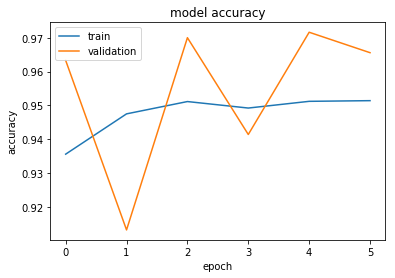

In [195]:
from matplotlib import pyplot as plt

# List all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

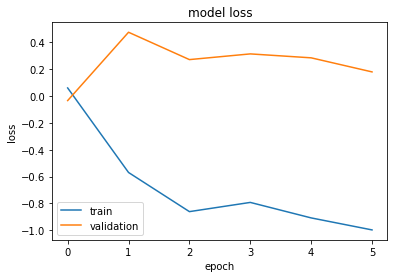

In [196]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

In [197]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 3, 44)             10384     
_________________________________________________________________
dense_16 (Dense)             (None, 3, 44)             1980      
_________________________________________________________________
lstm_12 (LSTM)               (None, 44)                15664     
_________________________________________________________________
dense_17 (Dense)             (None, 44)                1980      
_________________________________________________________________
dropout_6 (Dropout)          (None, 44)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________


## 8. Save the predictions and actual value to evaluate the model

The predictions are floating point values and we recode them as 1 if greater than 0.5 and 0 otherwise.

In [198]:
testY_predict = model.predict(testX)

In [199]:
print(testY_predict)

[[2.3806987e-03]
 [2.0367812e-02]
 [1.0000000e+00]
 ...
 [4.9941172e-04]
 [3.5285967e-04]
 [2.7609130e-04]]


In [200]:
print(len(testZ), len(testY_predict))

9656 9656


In [201]:
predicted = []
actual = []
for i in range(len(testZ)):
    #print(int(testY_predict[i]>0.5), int(testZ[i]>0.5))
    predicted.append(int(testY_predict[i]>0.5))
    actual.append(int(testZ[i]>0.5))

In [202]:
PREDICTIONS_DF = pd.DataFrame(list(zip(predicted, actual)),
  columns=['predicted','actual'])

In [203]:
PREDICTIONS_DF.head()

,predicted,actual
0,0,1
1,0,0
2,1,0
3,1,0
4,0,0


In [204]:
# write dataframe to .csv
SAVE_PATH = './Predicted Data_model_csv format/'
PREDICTIONS_DF.to_csv(SAVE_PATH+'Sub'+SUBJECT_ID+'_'+ ACTIVITY + '_'+ EVENT + '.csv', encoding='utf-8')